In [1]:
import pandas as pd

file = 'model/20250511_151159_efficient_labelled_1.0/csv_logs/lightning_logs/version_0/metrics.csv'
df = pd.read_csv(file)

In [2]:
df.columns

Index(['epoch', 'step', 'train_acc_epoch', 'train_acc_step',
       'train_loss_epoch', 'train_loss_step', 'val_acc', 'val_loss'],
      dtype='object')

In [3]:
# evolution of train_acc_epoch by epochs 
df.iloc[df['train_acc_epoch'].dropna().index][['train_loss_epoch', 'train_acc_epoch']]

,train_loss_epoch,train_acc_epoch
541,2.588709,0.434178
1084,1.818211,0.589161
1627,1.542749,0.644817


In [4]:
df.groupby('epoch').apply(len, include_groups=False)

epoch
0    542
1    543
2    543
3    308
dtype: int64

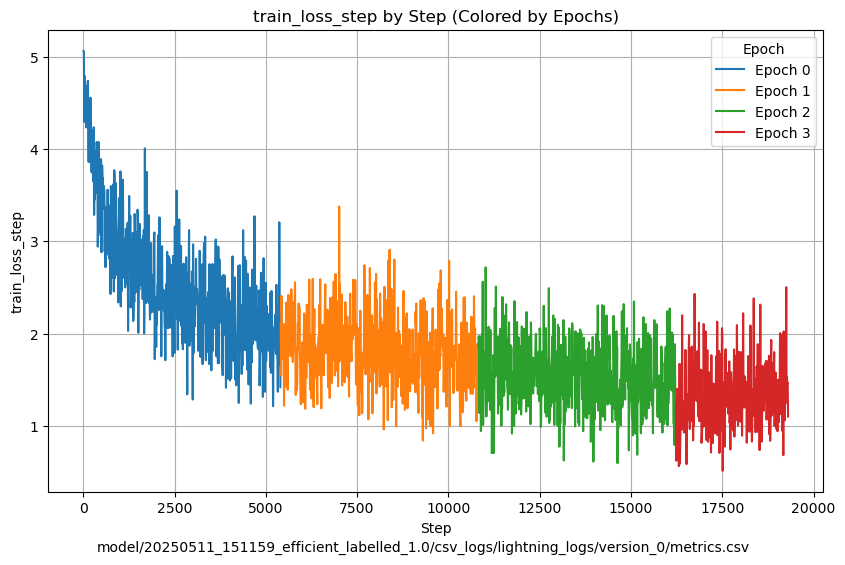

In [5]:
import matplotlib.pyplot as plt

def plot_column_evolution(df: pd.DataFrame, col: str, footer_note: str = ''):
    plt.figure(figsize=(10, 6))

    for epoch in df['epoch'].unique():
        subset = df[df['epoch'] == epoch]
        plt.plot(subset['step'], subset[col], label=f'Epoch {epoch}')

    plt.xlabel('Step')
    plt.ylabel(col)
    plt.title(f'{col} by Step (Colored by Epochs)')
    plt.legend(title='Epoch')
    plt.grid(True)
    
    if footer_note:
        plt.figtext(0.5, 0.01, footer_note, wrap=True, horizontalalignment='center', fontsize=10)

    plt.show()

plot_column_evolution(df, 'train_loss_step', file)

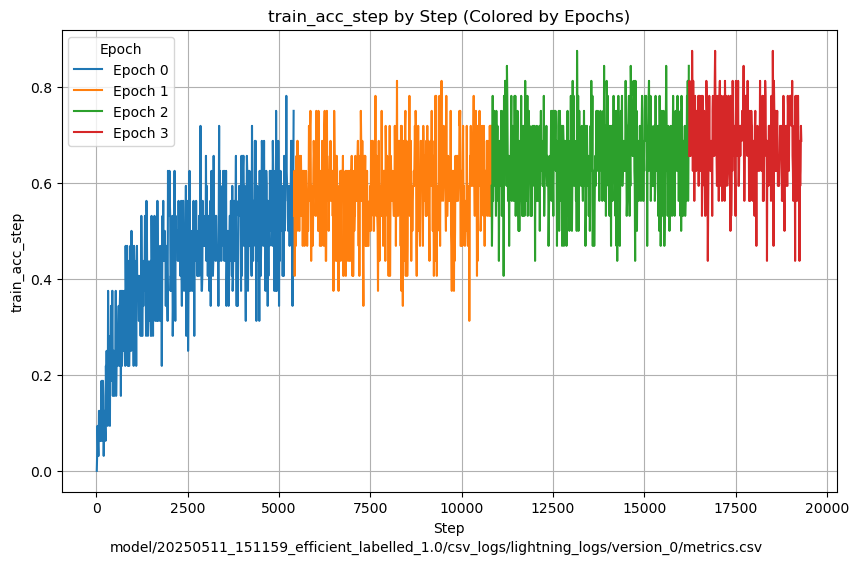

In [6]:
plot_column_evolution(df, 'train_acc_step', file)